Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [6]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import matplotlib.pyplot as plt
import numpy as np
import os
import tarfile
import urllib
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
import cPickle as pickle

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [7]:
url = 'http://yaroslavvb.com/upload/notMNIST/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urllib.urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print 'Found and verified', filename
  else:
    raise Exception(
      'Failed to verify' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [3]:
num_classes = 10

def extract(filename):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if not os.path.exists(root):
   tar = tarfile.open(filename)
   tar.extractall()
   tar.close()
  data_folders = [os.path.join(root, d) for d in sorted(os.listdir(root))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print data_folders
  return data_folders
  
train_folders = extract(train_filename)
test_folders = extract(test_filename)

['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [8]:
from IPython.display import Image, display
def show_samples_from_folders(folder_list):
  """I'm with stupid ->"""
  for folder in folder_list:
    for fname in os.listdir(folder):
        fullfname = os.path.join(folder,fname)
        if os.path.isfile(fullfname):
            if os.path.splitext(fname)[1] == ".png":
                print(fullfname)
                display(Image(filename=fullfname))
                break
                
show_samples_from_folders(test_folders)

notMNIST_small/A/Q3VydmF0dXJlLVJvdW5kZWRJdGFsaWMub3Rm.png


notMNIST_small/B/Q3VydmF0dXJlLVJvdW5kZWRJdGFsaWMub3Rm.png


notMNIST_small/C/Q3VydmF0dXJlLVJvdW5kZWRJdGFsaWMub3Rm.png


notMNIST_small/D/Q3VydmF0dXJlLVJvdW5kZWRJdGFsaWMub3Rm.png


notMNIST_small/E/Q3VydmF0dXJlLVJvdW5kZWRJdGFsaWMub3Rm.png


notMNIST_small/F/Q3VydmF0dXJlLVJvdW5kZWRJdGFsaWMub3Rm.png


notMNIST_small/G/Q3VydmF0dXJlLVJvdW5kZWRJdGFsaWMub3Rm.png


notMNIST_small/H/Q3VydmF0dXJlLVJvdW5kZWRJdGFsaWMub3Rm.png


notMNIST_small/I/Q3VydmF0dXJlLVJvdW5kZWRJdGFsaWMub3Rm.png


notMNIST_small/J/Q3VydmF0dXJlLVJvdW5kZWRJdGFsaWMub3Rm.png


Now let's load the data in a more manageable format.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. The labels will be stored into a separate array of integers 0 through 9.

A few images might not be readable, we'll just skip them.

In [9]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load(data_folders, min_num_images, max_num_images):
  dataset = np.ndarray(
    shape=(max_num_images, image_size, image_size), dtype=np.float32)
  labels = np.ndarray(shape=(max_num_images), dtype=np.int32)
  label_index = 0
  image_index = 0
  for folder in data_folders:
    print folder
    for image in os.listdir(folder):
      if image_index >= max_num_images:
        raise Exception('More images than expected: %d >= %d' % (
          image_index, max_num_images))
      image_file = os.path.join(folder, image)
      try:
        image_data = (ndimage.imread(image_file).astype(float) -
                      pixel_depth / 2) / pixel_depth
        if image_data.shape != (image_size, image_size):
          raise Exception('Unexpected image shape: %s' % str(image_data.shape))
        dataset[image_index, :, :] = image_data
        labels[image_index] = label_index
        image_index += 1
      except IOError as e:
        print 'Could not read:', image_file, ':', e, '- it\'s ok, skipping.'
    label_index += 1
  num_images = image_index
  dataset = dataset[0:num_images, :, :]
  labels = labels[0:num_images]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' % (
        num_images, min_num_images))
  print 'Full dataset tensor:', dataset.shape
  print 'Mean:', np.mean(dataset)
  print 'Standard deviation:', np.std(dataset)
  print 'Labels:', labels.shape
  return dataset, labels
#was 450000, 550000
#and 18000, 20000


In [10]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

np.random.seed(133)

def test_n_purge_input_files(data_folders, purge):
  supported_ext = ['.png']
  image_index = 0
  label_index = 0
  for folder in data_folders:
    print folder
    for image in os.listdir(folder):
      if os.path.splitext(image)[1] in supported_ext:
          image_file = os.path.join(folder, image)
          try:
            image_data = (ndimage.imread(image_file).astype(float) -
                          pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
              print 'Strange shape!'
              raise IOError
            image_index += 1
          except IOError as e:
            if purge:
              os.remove(image_file)
            print 'Could not read:', image_file, ':', e, '-, purging it to trash.'
    if len(os.listdir(folder)) > 0:
      print "label_index ", label_index, " assigned to ", folder
      label_index += 1
  print "Total: ", label_index, "indexes, ", image_index , " images."
  return label_index, image_index
    
def load_n_shuffle(data_folders, num_img):
  """Had to make this, /'cause don't have enough memory for separate shuffling"""
  supported_ext = ['.png']
  image_index = 0
  label_index = 0
    
  permutation = np.random.permutation(num_img)
  dataset = np.ndarray(
    shape=(num_img, image_size, image_size), dtype=np.float32)
  labels = np.ndarray(shape=(num_img), dtype=np.int32)
    
  try:  
   for folder in data_folders:
    for image in os.listdir(folder):
      if os.path.splitext(image)[1] in supported_ext:
            image_file = os.path.join(folder, image)
            image_data = (ndimage.imread(image_file).astype(float) -
                          pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
              print 'What a strange shape!'
              raise IOError
            dataset[permutation[image_index], :, :] = image_data
            labels[permutation[image_index]] = label_index
            if image_index > num_img:
                raise Exception('fck, it\'s too long')
            image_index += 1
    if len(os.listdir(folder)) > 0:
      print "label_index ", label_index, " assigned to ", folder
      label_index += 1
   if image_index < num_img:
     raise Exception('fck, it\'s too short')
   print "Total: ", label_index, "indexes, ", image_index , " images."
            
   num_images = image_index
  except IOError as e:
            print 'Could not read:', image_file, ':', e, '-, can\'t deal with it, need exact number of imgs.'
  return dataset, labels

def dataset_info(dataset, labels):
   print 'Full dataset tensor:', dataset.shape
   print 'Mean:', np.mean(dataset)
   print 'Standard deviation:', np.std(dataset)
   print 'Labels:', labels.shape


_, train_img_num = test_n_purge_input_files(train_folders, True)

notMNIST_large/A
label_index  0  assigned to  notMNIST_large/A
notMNIST_large/B
label_index  1  assigned to  notMNIST_large/B
notMNIST_large/C
label_index  2  assigned to  notMNIST_large/C
notMNIST_large/D
label_index  3  assigned to  notMNIST_large/D
notMNIST_large/E
label_index  4  assigned to  notMNIST_large/E
notMNIST_large/F
label_index  5  assigned to  notMNIST_large/F
notMNIST_large/G
label_index  6  assigned to  notMNIST_large/G
notMNIST_large/H
label_index  7  assigned to  notMNIST_large/H
notMNIST_large/I
label_index  8  assigned to  notMNIST_large/I
notMNIST_large/J
label_index  9  assigned to  notMNIST_large/J
Total:  10 indexes,  529114  images.


In [11]:
train_dataset, train_labels = load_n_shuffle(train_folders, train_img_num)

label_index  0  assigned to  notMNIST_large/A
label_index  1  assigned to  notMNIST_large/B
label_index  2  assigned to  notMNIST_large/C
label_index  3  assigned to  notMNIST_large/D
label_index  4  assigned to  notMNIST_large/E
label_index  5  assigned to  notMNIST_large/F
label_index  6  assigned to  notMNIST_large/G
label_index  7  assigned to  notMNIST_large/H
label_index  8  assigned to  notMNIST_large/I
label_index  9  assigned to  notMNIST_large/J
Total:  10 indexes,  529114  images.


In [12]:
_, test_img_num = test_n_purge_input_files(test_folders, True)
test_dataset, test_labels = load_n_shuffle(test_folders, test_img_num)

notMNIST_small/A
label_index  0  assigned to  notMNIST_small/A
notMNIST_small/B
label_index  1  assigned to  notMNIST_small/B
notMNIST_small/C
label_index  2  assigned to  notMNIST_small/C
notMNIST_small/D
label_index  3  assigned to  notMNIST_small/D
notMNIST_small/E
label_index  4  assigned to  notMNIST_small/E
notMNIST_small/F
label_index  5  assigned to  notMNIST_small/F
notMNIST_small/G
label_index  6  assigned to  notMNIST_small/G
notMNIST_small/H
label_index  7  assigned to  notMNIST_small/H
notMNIST_small/I
label_index  8  assigned to  notMNIST_small/I
notMNIST_small/J
label_index  9  assigned to  notMNIST_small/J
Total:  10 indexes,  18724  images.
label_index  0  assigned to  notMNIST_small/A
label_index  1  assigned to  notMNIST_small/B
label_index  2  assigned to  notMNIST_small/C
label_index  3  assigned to  notMNIST_small/D
label_index  4  assigned to  notMNIST_small/E
label_index  5  assigned to  notMNIST_small/F
label_index  6  assigned to  notMNIST_small/G
label_index 

In [49]:
dataset_info(train_dataset, train_labels)
dataset_info(test_dataset, test_labels)

Full dataset tensor: (200000, 28, 28)
Mean: -0.0817419
Standard deviation: 0.454188
Labels: (200000,)
Full dataset tensor: (18724, 28, 28)
Mean: -0.0746363
Standard deviation: 0.458622
Labels: (18724,)


---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [ ]:
#randomized it before, cause ididnt had enuf mmry

---
Problem 3
---------
Convince yourself that the data is still good after shuffling!

---

Label:  3
Label:  5
Label:  6
Label:  7
Label:  9
Label:  4
Label:  4
Label:  3
Label:  1
Label:  9


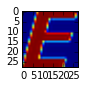

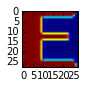

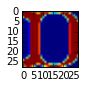

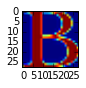

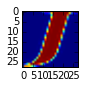

In [39]:

def show_samples(dataset,labels,start,num):
    %matplotlib inline
    i = start
    while i<(start+num):
        print "Label: ", labels[i] 
        img = dataset[i,:,:]
        plt.figure(figsize=(1,1),frameon=False)
        plt.imshow(img)
        i+=1

show_samples(train_dataset,train_labels,10,5)
show_samples(test_dataset,test_labels,10,5)

---
Problem 4
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [50]:
def show_me_balance(labels):
    i=0
    s = np.sum(labels != -1)
    print("Total count: ", s)
    while i<10:
        c = np.sum(labels == i)
        print("Label: ", i, "  Count: ",c,"  Percent: %.2f" % (100*c/s))
        i+=1
show_me_balance(test_labels)        

('Total count: ', 18724)
('Label: ', 0, '  Count: ', 1872, '  Percent: 9.00')
('Label: ', 1, '  Count: ', 1873, '  Percent: 10.00')
('Label: ', 2, '  Count: ', 1873, '  Percent: 10.00')
('Label: ', 3, '  Count: ', 1873, '  Percent: 10.00')
('Label: ', 4, '  Count: ', 1873, '  Percent: 10.00')
('Label: ', 5, '  Count: ', 1872, '  Percent: 9.00')
('Label: ', 6, '  Count: ', 1872, '  Percent: 9.00')
('Label: ', 7, '  Count: ', 1872, '  Percent: 9.00')
('Label: ', 8, '  Count: ', 1872, '  Percent: 9.00')
('Label: ', 9, '  Count: ', 1872, '  Percent: 9.00')


Prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed.

Also create a validation dataset for hyperparameter tuning.

In [13]:
train_size = 200000
valid_size = 10000

valid_dataset = train_dataset[:valid_size,:,:]
valid_labels = train_labels[:valid_size]
train_dataset = train_dataset[valid_size:valid_size+train_size,:,:]
train_labels = train_labels[valid_size:valid_size+train_size]
print 'Training', train_dataset.shape, train_labels.shape
print 'Validation', valid_dataset.shape, valid_labels.shape

Training (200000, 28, 28) (200000,)
Validation (10000, 28, 28) (10000,)


Finally, let's save the data for later reuse:

In [14]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print 'Unable to save data to', pickle_file, ':', e
  raise

In [15]:
statinfo = os.stat(pickle_file)
print 'Compressed pickle size:', statinfo.st_size

Compressed pickle size: 718193801


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.
Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [2]:
import cPickle as pickle
import numpy as np
from sklearn.linear_model import LogisticRegression

In [3]:
#i don't want to use previious steps, cause it will be long
# so let's just copy pickle load from 2_notmnist....
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print 'Training set', train_dataset.shape, train_labels.shape
  print 'Validation set', valid_dataset.shape, valid_labels.shape
  print 'Test set', test_dataset.shape, test_labels.shape

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (18724, 28, 28) (18724,)


In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = labels
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print 'Training set', train_dataset.shape, train_labels.shape
print 'Validation set', valid_dataset.shape, valid_labels.shape
print 'Test set', test_dataset.shape, test_labels.shape

Training set (200000, 784) (200000,)
Validation set (10000, 784) (10000,)
Test set (18724, 784) (18724,)


In [8]:
logreg = LogisticRegression(C=1e5)
numfit = 5000
numtest = 1000
X = train_dataset[:numfit,:]
Y = train_labels[:numfit]
logreg.fit(X, Y)
X_test = test_dataset[:numtest,:]
X_test_lbl = test_labels[:numtest]
predicted = logreg.predict(X_test)
print (predicted==X_test_lbl).sum()


784
